In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import numpy as np
import tensorflow as tf
from keras import layers
from keras.datasets import mnist
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import  Dropout, Reshape
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.initializers import glorot_uniform
from keras.models import Model

In [3]:
def reshaping(x):
  return np.reshape(x,(32,32))

a = np.load('/content/drive/MyDrive/dev dataset/train_data.npz')
x_train, y_train = a['arr_0'], a['arr_1']

xx_train = list((map(reshaping,x_train)))
x_train_ = np.array(xx_train)


b = np.load('/content/drive/MyDrive/dev dataset/test_data.npz')
x_test, y_test = b['arr_0'], b['arr_1']

xx_test = list((map(reshaping,x_test)))
x_test_ = np.array(xx_test)

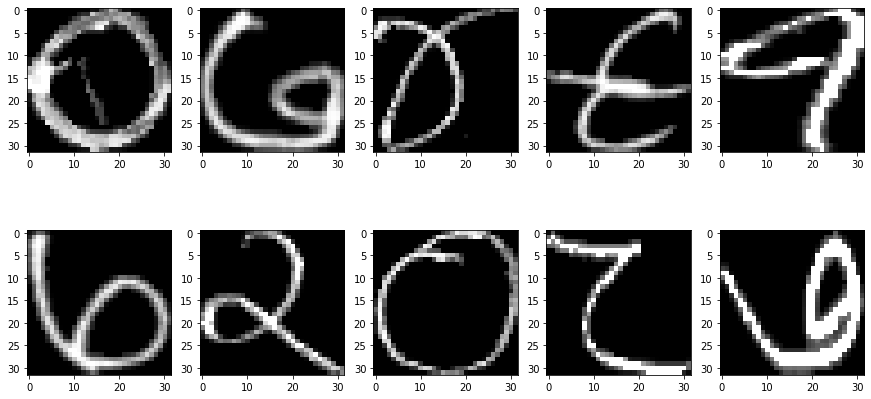

Labels : [[0]
 [7]
 [4]
 [9]
 [1]]
Labels : [[7]
 [2]
 [0]
 [8]
 [7]]


In [4]:
fig1 = plt.figure(figsize = (15,15))

for i in range(5):
    ax1 = fig1.add_subplot(1,5,i+1) 
    ax1.imshow(x_train_[i], interpolation='none', cmap=plt.cm.gray)
    ax2 = fig1.add_subplot(2,5,i+6) 
    ax2.imshow(x_train_[i+6], interpolation='none', cmap=plt.cm.gray)
plt.show()

print("Labels : {}".format(y_train[0:5]))
print("Labels : {}".format(y_train[6:11]))

In [5]:
# Normalizing the input
x_train_ = x_train_.astype('float32')
x_train_/=255

x_test_ = x_test_.astype('float32')
x_test_/=255

print(x_train_.shape)
print(x_test_.shape)

(18000, 32, 32)
(3750, 32, 32)


In [6]:
y_train_ = to_categorical(y_train, num_classes=10, dtype='float32')
y_test_ = to_categorical(y_test, num_classes=10, dtype='float32')

print("Train Set Size = {} images".format(y_train.shape[0]))
print("Test Set Size = {} images".format(y_test.shape[0]))

Train Set Size = 18000 images
Test Set Size = 3750 images


In [7]:
optimizer = 'adam'
objective = 'categorical_crossentropy'

def two_conv_pool(x, F1, F2, name):
    x = Conv2D(F1, (3, 3), activation=None, padding='same', name='{}_conv1'.format(name))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(F2, (3, 3), activation=None, padding='same', name='{}_conv2'.format(name))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='{}_pool'.format(name))(x)

    return x

def three_conv_pool(x, F1, F2, F3, name):
        x = Conv2D(F1, (3, 3), activation=None, padding='same', name='{}_conv1'.format(name))(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2D(F2, (3, 3), activation=None, padding='same', name='{}_conv2'.format(name))(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2D(F3, (3, 3), activation=None, padding='same', name='{}_conv3'.format(name))(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = MaxPooling2D((2, 2), strides=(2, 2), name='{}_pool'.format(name))(x)

        return x

def vggModel():
        # Define the input as a tensor with shape input_shape
        X_input = Input((32,32,1))
        
        # Zero-Padding
        net = ZeroPadding2D((3, 3))(X_input)

        net = two_conv_pool(net, 64, 64, "block1")
        net = two_conv_pool(net, 128, 128, "block2")
        net = three_conv_pool(net, 256, 256, 256, "block3")
        net = three_conv_pool(net, 512, 512, 512, "block4")
        #net = three_conv_pool(net, 512, 512, 512, "block5")

        net = Dropout(rate=.2)(net)
        net = Flatten()(net)
        net = Dropout(rate=.5)(net)

        net = Dense(2048, activation='relu', name='fc1')(net)
        net = Dropout(rate=.2)(net)
        net = Dense(1024, activation='relu', name='fc2')(net)
        net = Dropout(rate=.2)(net)
        net = Dense(10, activation='softmax', name='predictions')(net)

        # Create model
        model = Model(inputs = X_input, outputs = net, name='vgg16')
        model.compile(optimizer=optimizer, loss=objective, metrics=['accuracy'])
    
        return model

In [8]:
model_n = vggModel()
model_n.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 zero_padding2d (ZeroPadding  (None, 38, 38, 1)        0         
 2D)                                                             
                                                                 
 block1_conv1 (Conv2D)       (None, 38, 38, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 38, 38, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 38, 38, 64)        0         
                                                                 
 block1_conv2 (Conv2D)       (None, 38, 38, 64)        36928 

In [9]:
nb_epoch = 100
batch_size = 64

# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

ret = model_n.fit(x_train_.reshape((-1,32,32,1)), y_train_, 
                  epochs=nb_epoch, batch_size=batch_size, verbose=1,
                  #validation_split=0.3,
                  validation_data=(x_test_, y_test_),
                  callbacks=[es])

Epoch 1/100
282/282 [==============================] - 45s 132ms/step - loss: 1.1474 - accuracy: 0.6227 - val_loss: 1.4825 - val_accuracy: 0.5589
Epoch 2/100
282/282 [==============================] - 36s 127ms/step - loss: 0.0905 - accuracy: 0.9753 - val_loss: 0.1852 - val_accuracy: 0.9485
Epoch 3/100
282/282 [==============================] - 36s 127ms/step - loss: 0.0508 - accuracy: 0.9858 - val_loss: 0.0882 - val_accuracy: 0.9760
Epoch 4/100
282/282 [==============================] - 36s 127ms/step - loss: 0.0410 - accuracy: 0.9888 - val_loss: 0.0827 - val_accuracy: 0.9813
Epoch 5/100
282/282 [==============================] - 36s 127ms/step - loss: 0.0343 - accuracy: 0.9906 - val_loss: 0.0835 - val_accuracy: 0.9837
Epoch 6/100
282/282 [==============================] - 36s 129ms/step - loss: 0.0332 - accuracy: 0.9911 - val_loss: 0.0728 - val_accuracy: 0.9816
Epoch 7/100
282/282 [==============================] - 36s 127ms/step - loss: 0.0235 - accuracy: 0.9947 - val_loss: 0.1184 -

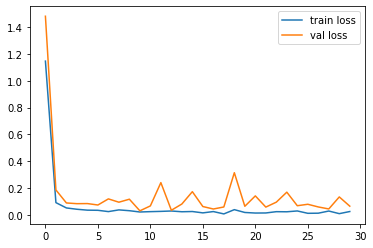

In [10]:
plt.plot(ret.history['loss'], label='train loss')
plt.plot(ret.history['val_loss'], label='val loss')
plt.legend()
plt.show()

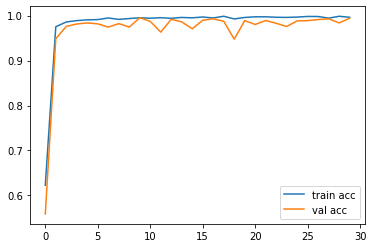

In [11]:
plt.plot(ret.history['accuracy'], label='train acc')
plt.plot(ret.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [12]:
# evaluate the model
_, train_acc = model_n.evaluate(x_train_, y_train_, verbose=0)
_, test_acc = model_n.evaluate(x_test_, y_test_, verbose=0)
print('Train accuracy: %.3f, Test accuracy: %.3f' % (train_acc, test_acc))

Train accuracy: 1.000, Test accuracy: 0.994


In [13]:
predictions = model_n.predict(x_test_.reshape((-1,32,32,1)), verbose=0)

In [14]:
def test_accuracy():
    err = []
    t = 0
    for i in range(predictions.shape[0]):
        if (np.argmax(predictions[i]) == y_test[i]):
            t = t+1
        else:
            err.append(i)
    return t, float(t)*100/predictions.shape[0], err

In [15]:
p = test_accuracy()
print("Test accuracy: {} %".format(p[1]))

Test accuracy: 99.41333333333333 %


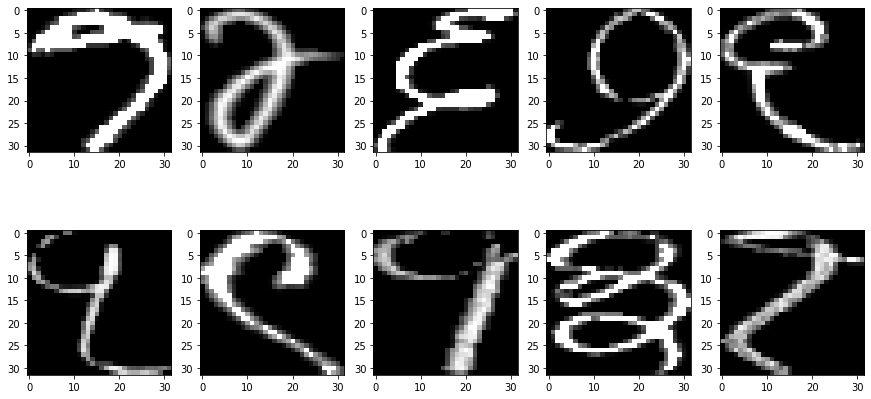

True:          [[1]
 [4]
 [6]
 [1]
 [6]]
classified as: [0 2 9 7 2]
True:          [[1]
 [9]
 [1]
 [3]
 [1]]
classified as: [5 2 5 6 2]


In [16]:
fig1 = plt.figure(figsize = (15,15))

for i in range(5):
    ax1 = fig1.add_subplot(1,5,i+1) 
    ax1.imshow(x_test_[p[2][i]], interpolation='none', cmap=plt.cm.gray)
    ax2 = fig1.add_subplot(2,5,i+6) 
    ax2.imshow(x_test_[p[2][i+6]], interpolation='none', cmap=plt.cm.gray)
plt.show()

print("True:          {}".format(y_test[p[2][0:5]]))
print("classified as: {}".format(np.argmax(predictions[p[2][0:5]], axis=1)))

print("True:          {}".format(y_test[p[2][6:11]]))
print("classified as: {}".format(np.argmax(predictions[p[2][6:11]], axis=1)))